In [2]:
# Importing libraries #
import re, string
import nltk
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sn
import language_tool_python
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from textacy import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

tool = language_tool_python.LanguageTool('es-US')
stemmer = SnowballStemmer('spanish')

In [1]:
# Deifining key functions #

# Preprocessing paragraphs #

def process_paragraph(paragraph):
    """
    This function removes non representative string characters
    input: paragraph extracted from plain text file
    output: paragraph withoput stopwords and punctuation
    """

    # Function for data cleaning #
    def text_cleaning(text_to_clean):
        """
        This function cleans the text data
         """
        text_to_clean = preprocessing.remove.punctuation(text_to_clean)
        text_to_clean = preprocessing.remove.accents(text_to_clean)
        text_to_clean = preprocessing.normalize.whitespace(text_to_clean)
        text_to_clean = preprocessing.normalize.unicode(text_to_clean)
        return text_to_clean
    
    # Function for removing stopwords #
    def stopword(string):
        a = [i for i in string.split() if i not in stopwords.words('spanish')]
        return ' '.join(a)

    # Stemming the paragraph #
    def stemming(text_to_process):
        return ' '.join([ stemmer.stem(i) for i in text_to_process.split() ])

    # Correcting the input pragraph #
    new_paragraph =  stemming(stopword(text_cleaning(tool.correct(paragraph))))

    return new_paragraph

In [5]:
# Working with perdida dataset #
# Working with the data of decision #
df_solicitante = pd.read_csv("resources/list_solicitante.csv")
df_solicitante["Sentencia_cleaned"] = df_solicitante["sentences"].apply(lambda x: process_paragraph(x))

In [7]:
# Modeling #

# Splitting train data and test data 0.4 #
X_train, X_test, y_train, y_test = train_test_split(df_solicitante['Sentencia_cleaned'].astype(str), df_solicitante['Label'], test_size=0.4, shuffle=True, random_state=42)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), use_idf=True, max_features=300)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Para prediccion #
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [50]:
# Creating the model #
model = lgb.LGBMClassifier(max_bin=3,
                        max_depth=5,
                        lambda_l2=15,
                        num_leaves=7,
                        min_child_samples=10,
                        subsample=0.3,
                        colsample_bytree=0.5,
                        reg_alpha=1,
                        reg_lambda=10)

# Fitting the model to the tfidf vectors #
model.fit(X_train_vectors_tfidf, y_train)

# Estimating model accuracy #
y_pred = model.predict(X_test_vectors_tfidf)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

y_pred_train = model.predict(X_train_vectors_tfidf)
print("Training Accuracy:", metrics.accuracy_score(y_train, y_pred_train))

y_pred_proba = model.predict_proba(X_test_vectors_tfidf)

print("Distribucion del dataset:"+ '\n',df_solicitante["Label"].value_counts())

[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=10 will be ignored. Current value: lambda_l2=15
Accuracy: 0.8872437357630979
Training Accuracy: 0.8967350037965072
Distribucion del dataset:
 0    1843
1     352
Name: Label, dtype: int64


C:\Users\Martin V\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


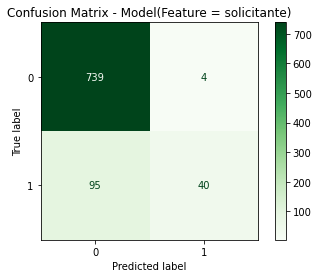

In [51]:
# Grafica de una matriz de confusion #

metrics.plot_confusion_matrix(model, X_test_vectors_tfidf, y_test, cmap='Greens')
plt.title('Confusion Matrix - Model(Feature = solicitante)')
plt.show()

In [10]:
# Pickle dumps #

path_model = "pickle_files/"
path_transformer = path_model
filename_model = "fitted_model_solicitante.pkl"
filename_transformer = "transformer_model_solicitante.pkl"
pickle.dump(model, open(path_model+filename_model, 'wb'))
pickle.dump(tfidf_vectorizer, open(path_transformer+filename_transformer, 'wb'))

In [48]:
# Exporting arrays for ROC Plotter #
arr = np.asarray ( y_test )
arr_proba = np.asarray ( y_pred_proba[:,1] )
#print(arr)
arr.tofile('modelGraphData/data_model_solicitante_yTest.csv', sep=',')
arr_proba.tofile('modelGraphData/data_model_solicitante_yProba.csv', sep=',')

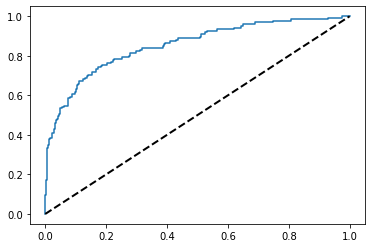

In [32]:
# Ploting ROC curve #
#metrics.plot_roc_curve(model,X_test_vectors_tfidf, y_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.show()